<a href="https://colab.research.google.com/github/yingzibu/ODE/blob/main/learn/nonmem/eta_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Calculate eta for one-compartment iv model

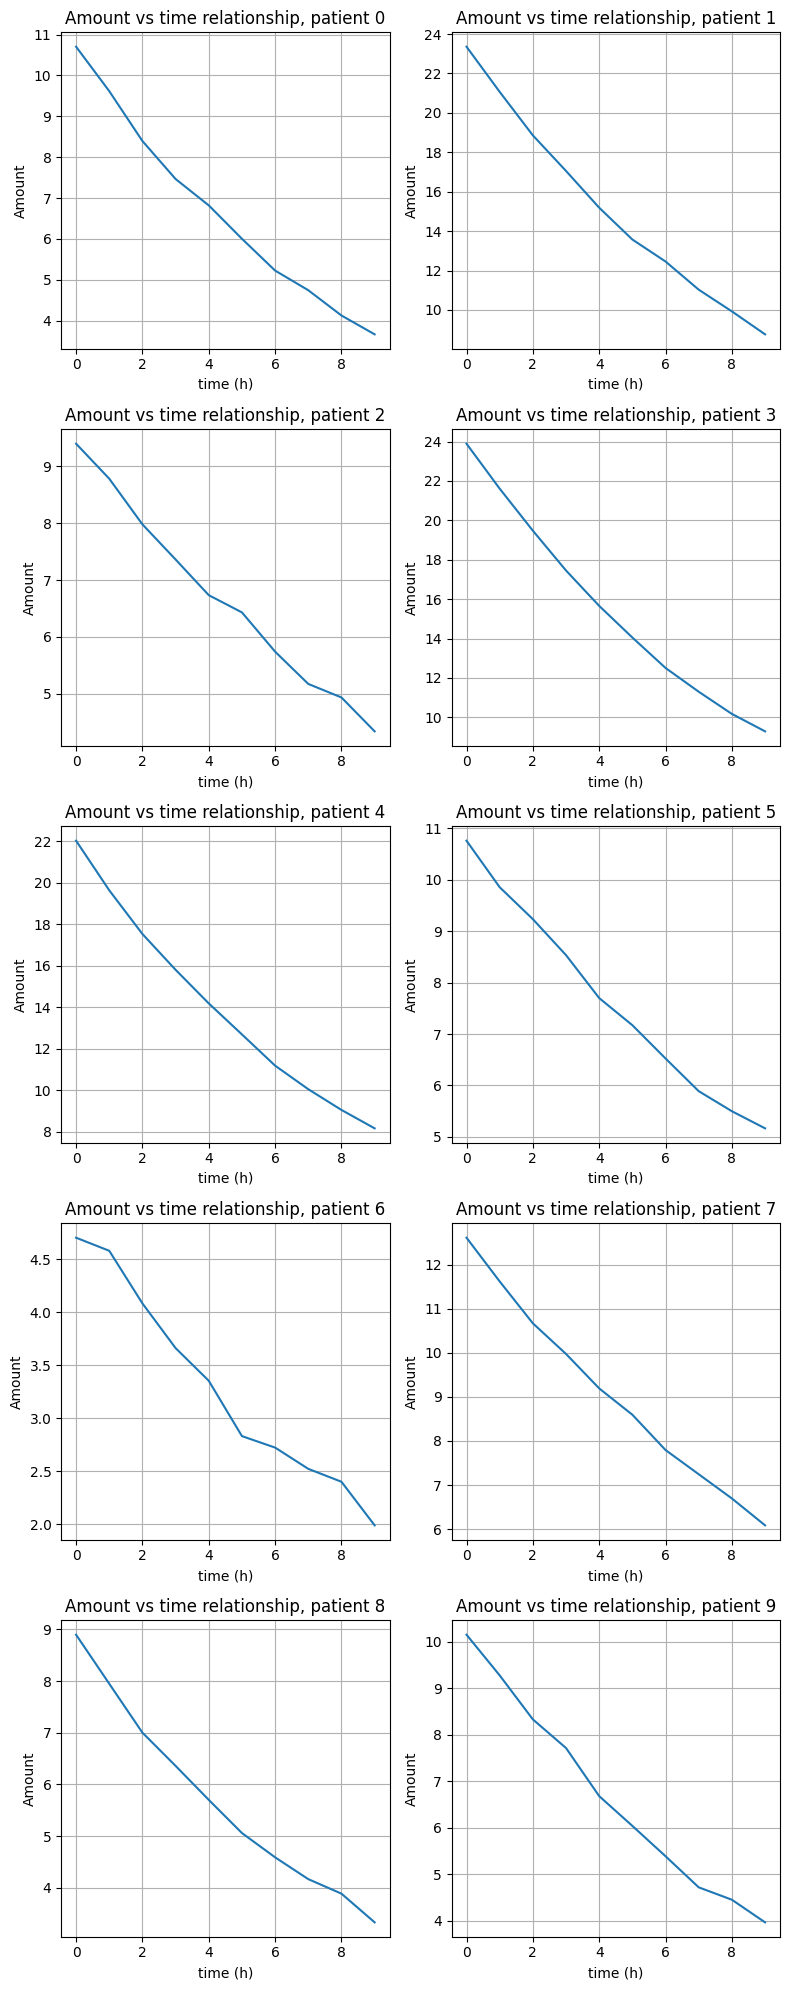

<ipython-input-10-d466ff1f2b6a>:80: RuntimeWarning: divide by zero encountered in log
  nll += -np.log(np.exp(-0.5 * ((observed - pred) ** 2) / 0.1**2) / (0.1 * np.sqrt(2 * np.pi)))


Estimated Parameters:
Clearance: 1.0
Volume: 10.0
Omega Clearance: 0.1
Omega Volume: 0.1


In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (3.5, 3)

# Simulated data
np.random.seed(42)
n_patients = 10
n_obs = 10

# Population parameters
pop_cl = 1.0  # Population clearance
pop_v = 10.0  # Population volume

# Variance of random effects (eta)
omega_cl = 0.1  # Variance for clearance
omega_v = 0.2   # Variance for volume

# Simulate data
data = []
for patient in range(n_patients):
    eta_cl = np.random.normal(0, np.sqrt(omega_cl))  # Random effect for clearance
    eta_v = np.random.normal(0, np.sqrt(omega_v))    # Random effect for volume
    for t in range(n_obs):
        dose = 100  # Dose amount
        time = t  # Time in hours
        # Simple PK model: C(t) = Dose / V * e^(-Cl/V * t)
        concentration = (dose / (pop_v * np.exp(eta_v))) * np.exp(-((pop_cl * np.exp(eta_cl)) / (pop_v)) * time)
        # Add some observation error
        concentration += np.random.normal(0, 0.1)  # Adding Gaussian noise
        data.append([patient, time, concentration])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['patient', 'time', 'concentration'])

fig, axs = plt.subplots(5,2, figsize=(8, 20))

for i in range(5):
    for j in range(2):
        unique_id = i*2 + j
        # print(unique_id)
        data_single = df[df['patient'] == unique_id]
        t = data_single['time']
        true_y = data_single['concentration']
        # pred_y = data_single['preds']
        # axs[i, j].plot(t, true_y, t, pred_y, 'g--')
        axs[i, j].plot(t, true_y)
        axs[i, j].set_title(f'Amount vs time relationship, patient {unique_id}')
        axs[i, j].set_xlabel('time (h)')
        axs[i, j].set_ylabel('Amount')

        axs[i, j].grid(True)
        # axs[i, j].legend(['True A', 'Pred A'])

# Adjust layout
plt.xlabel('time (h)')
plt.ylabel('Amount')
# plt.legend(['True A', 'Pred A'])
plt.tight_layout()
plt.show()

# Define the objective function to minimize
def objective(params, df):
    cl, v, omega_cl, omega_v = params
    nll = 0  # Negative log-likelihood
    for patient in df['patient'].unique():
        patient_data = df[df['patient'] == patient]
        eta_cl = np.random.normal(0, np.sqrt(omega_cl))
        eta_v = np.random.normal(0, np.sqrt(omega_v))

        for index, row in patient_data.iterrows():
            time = row['time']
            observed = row['concentration']
            # Model prediction
            pred = (100 / (v * np.exp(eta_v))) * np.exp(-((cl * np.exp(eta_cl)) / (v)) * time)
            # Assuming Gaussian error
            nll += -np.log(np.exp(-0.5 * ((observed - pred) ** 2) / 0.1**2) / (0.1 * np.sqrt(2 * np.pi)))

    return nll

# Initial parameter guesses
initial_params = [1.0, 10.0, 0.1, 0.1]  # [cl, v, omega_cl, omega_v]

# Minimize the objective function
result = minimize(objective, initial_params, args=(df,),
                  bounds=((0, None), (0, None), (0, None), (0, None)))

# Output the results
estimated_params = result.x
print("Estimated Parameters:")
print(f"Clearance: {estimated_params[0]}")
print(f"Volume: {estimated_params[1]}")
print(f"Omega Clearance: {estimated_params[2]}")
print(f"Omega Volume: {estimated_params[3]}")


In [9]:
result

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: nan
        x: [ 1.000e+00  1.000e+01  1.000e-01  1.000e-01]
      nit: 0
      jac: [       nan        nan        nan        nan]
     nfev: 105
     njev: 21
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>